In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import utils

from cmcrameri import cm
from scipy.interpolate import CubicSpline
from scipy.integrate import simpson

plt.rcParams.update(utils.rcparams)

In [2]:
N_min = 0
N_max = 20

N_list = list(range(N_min,N_max+1))

# Create a custom colormap
color_list = [cm.roma(N/N_max) for N in N_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )
norm = mpl.colors.Normalize(vmin=N_min-0.5, vmax=N_max+0.5)

In [3]:
ID = 1
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

### Start time from the mismatch

In [4]:
sim_info = utils.t0NM_finder(sim_info, N_max)

Calculating for n = 0
Calculating for n = 1
Calculating for n = 2
Calculating for n = 3
Calculating for n = 4
Calculating for n = 5
Calculating for n = 6
Calculating for n = 7
Calculating for n = 8
Calculating for n = 9
Calculating for n = 10
Calculating for n = 11
Calculating for n = 12
Calculating for n = 13
Calculating for n = 14
Calculating for n = 15
Calculating for n = 16
Calculating for n = 17
Calculating for n = 18
Calculating for n = 19
Calculating for n = 20


In [5]:
sim_info['t0_list'][0]

[np.float64(44.20783327052595), np.float64(-12.900163016807117)]

We can estimate the error on the NR by computing the mismatch between the two highest levels. We maximize the match over a phase and time shift (see `mismatch_calculations.ipynb` for more details).

In [6]:
sim_info_lev4 = utils.load_cce_data(ID, lev=4)
sim_lev4 = sim_info_lev4['sim']
chif_lev4 = sim_lev4.chif_mag
Mf_lev4 = sim_lev4.Mf

In [7]:
sim_Lev4_interp_h22 = CubicSpline(sim_lev4.times, np.real(sim_lev4.h[2,2]))(sim.times) + \
    1j*CubicSpline(sim_lev4.times, np.imag(sim_lev4.h[2,2]))(sim.times)

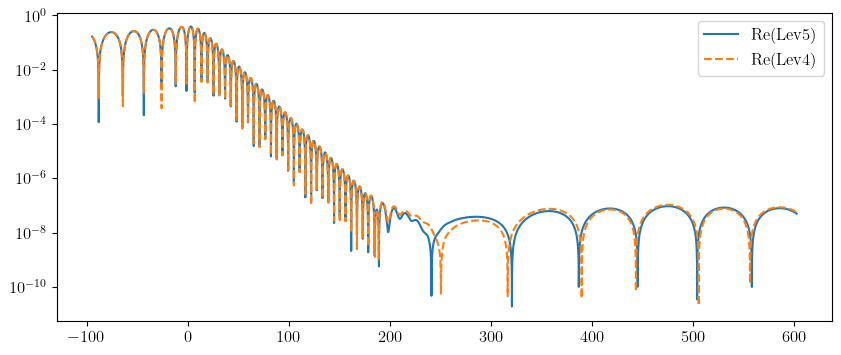

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(sim.times, abs(sim.h[2,2].real), c='C0', ls='-', label='Re(Lev5)')
ax.plot(sim.times, abs(sim_Lev4_interp_h22.real), c='C1', ls='--', label='Re(Lev4)')

ax.legend();

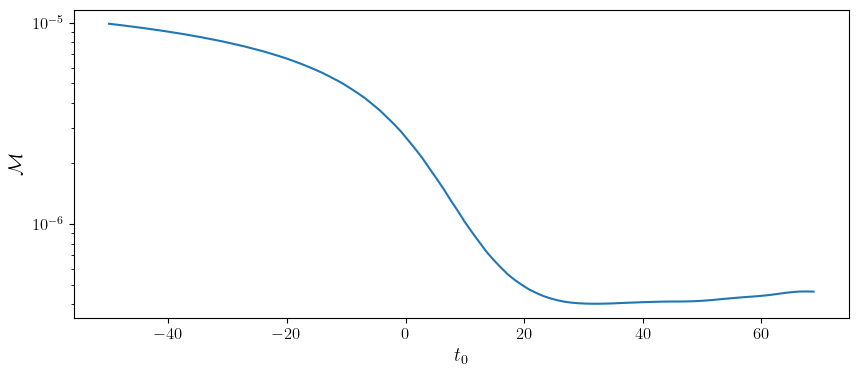

In [9]:
mm_default = []

nr_error_times = np.linspace(-50, 70, 100, endpoint=False)
T = 100
for t0 in nr_error_times:
    mask = (sim.times > t0) & (sim.times < t0+T)
    mm_default.append(qnmfits.mismatch(sim.times[mask], sim.h[2,2][mask], sim_Lev4_interp_h22[mask]))

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(nr_error_times, mm_default, c='C0', ls='-')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$\mathcal{M}$');

In [10]:
def phase_maximised_inner_product(times, x, y):
    z = np.trapezoid(x*np.conj(y), x=times)
    return abs(z)

def phase_optimized_mismatch(times, x, y):
    numerator = phase_maximised_inner_product(times, x, y)
    denominator = np.sqrt(phase_maximised_inner_product(times, x, x)*phase_maximised_inner_product(times, y, y))
    return 1 - numerator/denominator

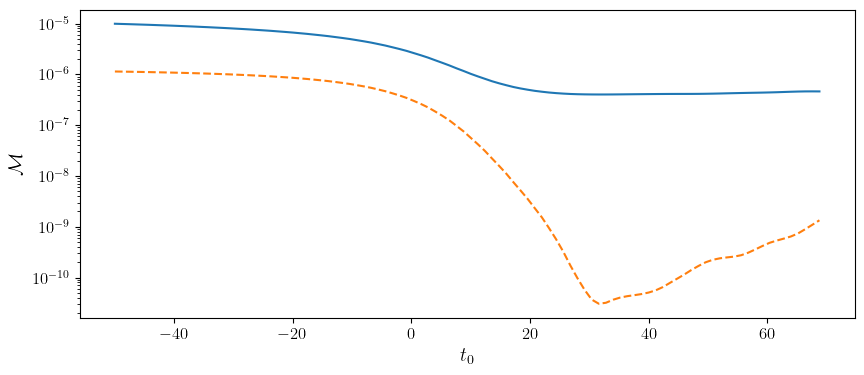

In [11]:
mm_phase = []

for t0 in nr_error_times:
    mask = (sim.times > t0) & (sim.times < t0+T)
    mm_phase.append(
        phase_optimized_mismatch(sim.times[mask], sim.h[2,2][mask], sim_Lev4_interp_h22[mask])
        )

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(nr_error_times, mm_default, c='C0', ls='-')
ax.plot(nr_error_times, mm_phase, c='C1', ls='--')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$\mathcal{M}$');

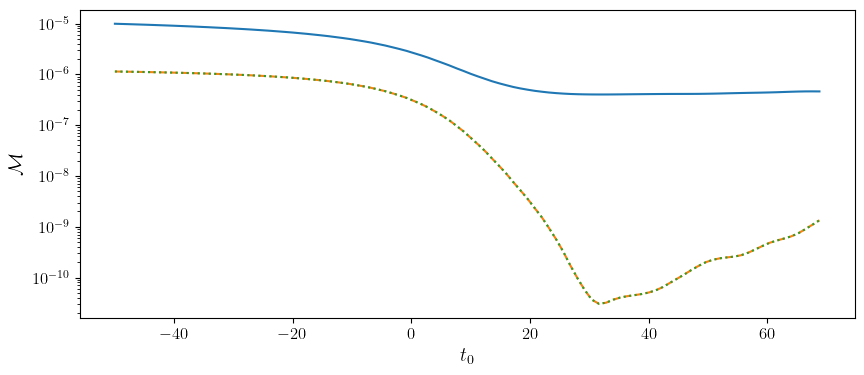

In [12]:
mm_phase_time = []

for t0 in nr_error_times:

    mask = (sim.times > t0) & (sim.times < t0+T)
    
    mm = 1
    
    for roll in [-4,-3,-2,-1,0,1,2,3,4]:
        
        sim_Lev4_interp_h22_rolled = np.roll(sim_Lev4_interp_h22, roll)
        
        mm_new = phase_optimized_mismatch(sim.times[mask], sim.h[2,2][mask], sim_Lev4_interp_h22_rolled[mask])
        
        if mm_new < mm:
            mm = mm_new
            preferred_roll = roll

    mm_phase_time.append(mm)

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(nr_error_times, mm_default, c='C0', ls='-')
ax.plot(nr_error_times, mm_phase, c='C1', ls='--')
ax.plot(nr_error_times, mm_phase_time, c='C2', ls=':')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$\mathcal{M}$');

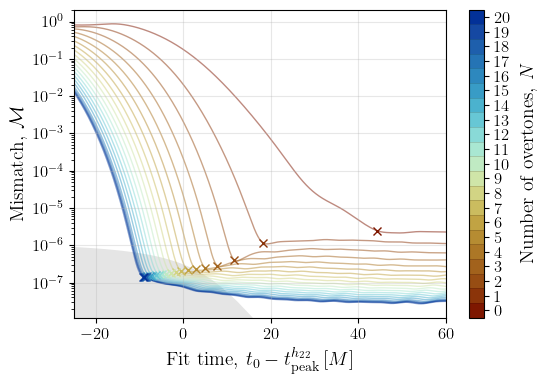

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    location='right',
    ticks=range(N_min, N_max+1),
)

cbar.set_label(r'Number of overtones, $N$', labelpad=7)

bounds = [n+0.5 for n in range(N_min, N_max)]
for bound in bounds:
    cbar.ax.axhline(bound, color='k', lw=0.5, alpha=0.2)

mm_times = sim.times[(sim.times > -30) & (sim.times < 100)]

for n in N_list:
    
    ax.plot(
        mm_times,
        sim_info['mm_lists'][n],
        color=cmap(n/N_max),
        zorder=1,
        alpha=0.5,
        lw=1
        )
    
    ax.plot(
        sim_info['t0_list'][n][0],
        np.exp(sim_info['t0_list'][n][1]),
        color=cmap(n/N_max),
        marker='x',
        markersize=6,
        zorder=2
    )

ylim = ax.get_ylim()

ax.fill_between(
        nr_error_times, 
        mm_phase_time, 
        1e-15,
        color='k', 
        alpha=0.1,
        zorder=0,
        linewidth=0
    )
    
ax.set_xlim(-25, 60)
ax.set_ylim(ylim)

ax.set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$');

Create a version of the mismatch curves where we also include $(3,2,0)$ in the model:

In [14]:
additional_modes = [(3,2,0,1)]
mode_list = utils.get_mode_list(N_max, additional_modes)

mm_lists = []
for i, modes in enumerate(mode_list):
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h[2, 2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=mm_times,
        t0_method='closest'
    )
    mm_lists.append(mm_list)

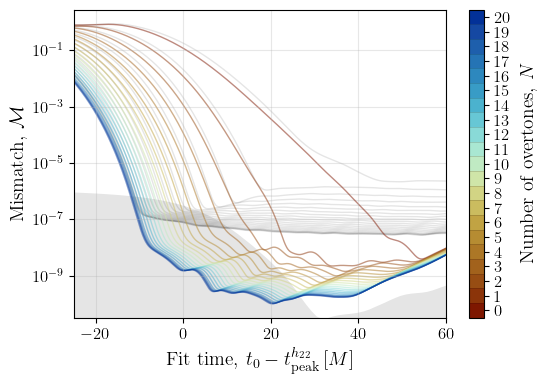

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    location='right',
    ticks=range(N_min, N_max+1),
)

cbar.set_label(r'Number of overtones, $N$', labelpad=7)

bounds = [n+0.5 for n in range(N_min, N_max)]
for bound in bounds:
    cbar.ax.axhline(bound, color='k', lw=0.5, alpha=0.2)

for n in N_list:

    ax.plot(
        mm_times,
        sim_info['mm_lists'][n],
        color='k',
        zorder=1,
        alpha=0.1,
        lw=1
        )
    
    ax.plot(
        mm_times,
        mm_lists[n],
        color=cmap(n/N_max),
        zorder=1.1,
        alpha=0.5,
        lw=1
        )
    
ylim = ax.get_ylim()

ax.fill_between(
        nr_error_times, 
        mm_phase_time, 
        1e-15,
        color='k', 
        alpha=0.1,
        zorder=0,
        linewidth=0
    )
    
ax.set_xlim(-25, 60)
ax.set_ylim(ylim)

ax.set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$');

### Start time from the remnant mass and spin recovery

In [16]:
epsilon_data = pd.read_csv('../data/epsilon_curves/1.csv', index_col=0)
eps_times = epsilon_data['t'].values

Our default estimate has some artifacts at early start times:

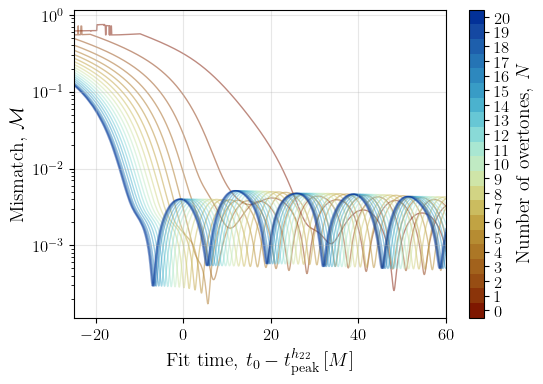

In [17]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(N_min, N_max+1),
    label=r'Number of overtones, $N$'
    )

for n in N_list:
    
    ax.plot(
        eps_times,
        epsilon_data[str(n)],
        color=cmap(n/N_max),
        zorder=1,
        alpha=0.5,
        lw=1
        )
    
ax.set_xlim(-25, 60)

ax.set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
ax.set_ylabel(r'Mismatch, $\mathcal{M}$');

Adjust the initial guess to help:

In [18]:
epsilon_dict = {}

for N in [0, 1]:

    epsilon_dict[N] = []
    modes = [(2, 2, n, 1) for n in range(N + 1)]
    
    for t0 in eps_times:

        if t0 < 0:
            x0 = [1.5, chif]
        else:
            x0 = [Mf, chif]
        
        epsilon = qnmfits.calculate_epsilon(
            sim.times, 
            data=sim.h[2,2], 
            modes=modes,
            Mf=Mf,
            chif=chif,
            t0=t0,
            t0_method='closest',
            T=100,
            x0=x0
        )
        
        epsilon_dict[N].append(epsilon[0])

In [19]:
t0E_data = pd.read_csv('../data/t0N_E.csv', index_col=0)

In [20]:
for N, t0 in enumerate(t0E_data[str(ID)]):
    print(f'N={N}, t0={t0}')

N=0, t0=33.742132907404084
N=1, t0=15.153719252498377
N=2, t0=10.779899661867605
N=3, t0=6.953284103231454
N=4, t0=5.625471780755106
N=5, t0=4.141176467705009
N=6, t0=2.7347770392334496
N=7, t0=1.3282886133820284
N=8, t0=0.1562623937370517
N=9, t0=-0.8594024551930488
N=10, t0=-1.87500921076753
N=11, t0=-2.734299075744275
N=12, t0=-3.515416125351294
N=13, t0=-4.296517347691406
N=14, t0=-4.921365816141588
N=15, t0=-5.624290903326255
N=16, t0=-6.170992380881216
N=17, t0=-6.717681111308593
N=18, t0=-6.4833873224069976
N=19, t0=-7.030075761389526
N=20, t0=-6.873878396523651
N=21, t0=-7.420565333529339


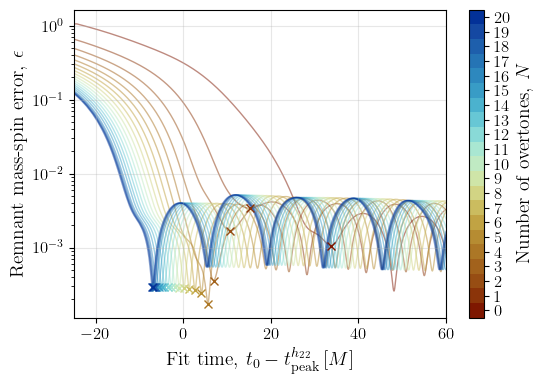

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(N_min, N_max+1),
    label=r'Number of overtones, $N$'
    )

for n in N_list:

    t0E = t0E_data[str(ID)].values[n]

    if n in epsilon_dict:
        epsilon_list = epsilon_dict[n]
    else:
        epsilon_list = epsilon_data[str(n)]

    t0E_epsilon = epsilon_list[np.argmin(np.abs(eps_times - t0E))]
    
    ax.plot(
        eps_times,
        epsilon_list,
        color=cmap(n/N_max),
        zorder=1,
        alpha=0.5,
        lw=1
        )
    
    ax.plot(
        t0E,
        t0E_epsilon,
        color=cmap(n/N_max),
        marker='x',
        markersize=6,
        zorder=2
    )
    
ax.set_xlim(-25, 60)

ax.set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
ax.set_ylabel(r'Remnant mass-spin error, $\epsilon$');

In [22]:
# Note that the error is below the axis limits:
epsilon_err = np.sqrt((Mf - Mf_lev4)**2 + (chif - chif_lev4)**2)
epsilon_err

np.float64(5.916995288981202e-06)

With $(3,2,0)$:

In [23]:
epsilon_data_with_320 = pd.read_csv('../data/epsilon_curves/1_with320.csv', index_col=0)
eps_times_with_320 = epsilon_data_with_320['t'].values

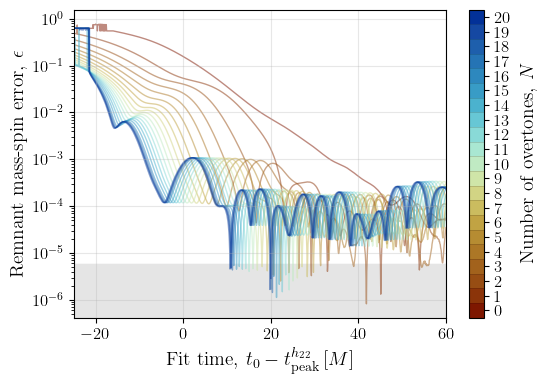

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    location='right',
    ticks=range(N_min, N_max+1),
)

cbar.set_label(r'Number of overtones, $N$', labelpad=7)

bounds = [n+0.5 for n in range(N_min, N_max)]
for bound in bounds:
    cbar.ax.axhline(bound, color='k', lw=0.5, alpha=0.2)

for n in N_list:
    
    ax.plot(
        eps_times_with_320,
        epsilon_data_with_320[str(n)],
        color=cmap(n/N_max),
        zorder=1,
        alpha=0.5,
        lw=1
        )
    
ylim = ax.get_ylim()

ax.fill_between(
        eps_times_with_320, 
        epsilon_err, 
        1e-15,
        color='k', 
        alpha=0.1,
        zorder=0,
        linewidth=0
    )
    
ax.set_xlim(-25, 60)
ax.set_ylim(ylim)

ax.set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
ax.set_ylabel(r'Remnant mass-spin error, $\epsilon$');

### Combined figure

In [25]:
t0M_data = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)

In [26]:
delta_t0_M = pd.read_csv('../data/Delta_t0_data_30_to_100.csv', index_col=0)
delta_t0_E = pd.read_csv('../data/Delta_t0N_E.csv', index_col=0)

In [27]:
N_min_Delta_t0 = 1
N_max_Delta_t0 = 17
N_list_Delta_t0 = list(range(N_min_Delta_t0,N_max_Delta_t0+1))

We can translate the gain in start time to a gain in SNR (the SNR gain is one of the advantages of including overtones in the ringdown). The SNR, $\rho$, is given by

\begin{align}
\rho^2 = 4 ~ \mathrm{Re} \int_0^\infty \frac{|\tilde{h}(f)|^2}{S_0(f)} ~ \mathrm{d}f. \nonumber
\end{align}

The ringdown occurs in a narrow range of frequencies, so we make the approximation $S_0(f) = S_0 = \mathrm{const}$ to get

\begin{align}
\rho^2 &\approx \frac{4}{S_0} ~ \mathrm{Re} \int_0^\infty |\tilde{h}(f)|^2 ~ \mathrm{d}f \nonumber \\ 
&\approx \frac{2}{S_0} ~ \mathrm{Re} \int_{-\infty}^\infty |\tilde{h}(f)|^2 ~ \mathrm{d}f \nonumber \\
&\approx \frac{2}{S_0} ~ \mathrm{Re} \int_0^\infty |h(t)|^2 ~ \mathrm{d}t \nonumber
\end{align}

where in the last line we used Parseval's theorem. If $\rho_N$ is the SNR of a ringdown model with $N$ overtones, then we can compute the ratio

\begin{align}
\frac{\rho_N}{\rho_0} = \mathrm{Re} \sqrt{ \frac{\int_0^\infty |h(t; t_0 = t_0^N)|^2 ~ \mathrm{d}t}{\int_0^\infty |h(t; t_0 = t_0^{N=0})|^2 ~ \mathrm{d}t} }. \nonumber
\end{align}

The PSD cancels out, as well as anything that multiplies $h$ (for example, the overall mass scale, or the distance to the source).

In [28]:
# Use the average of t0_M and t0_E
average_t0s = []
for t0_MN, t0_EN in zip(t0M_data['1'].values, t0E_data['1'].values):
    average_t0s.append((t0_MN + t0_EN)/2)
average_t0s = np.array(average_t0s)[:17+1]

In [29]:
wf_dict = {}
for N, t0 in enumerate(average_t0s):
    times = sim.times[sim.times >= t0]
    data = sim.h[2,2][sim.times >= t0]
    wf_dict[N] = {
        'times': times,
        'data': data,
    }

In [30]:
snr_list = []
for N in range(0, 17+1):
    wf = wf_dict[N]
    # Just work with hplus
    model = np.real(wf['data'])
    times = wf['times']

    # Calculate the SNR
    snr = np.sqrt(
        simpson(np.abs(model)**2, times)
    )
    snr_list.append(snr)

snr_list = np.array(snr_list)
print(f'Dividing by rho = {snr_list[0]} to normalize the SNR values.')
snr_list /= snr_list[0]
snr_list

Dividing by rho = 0.06188962953808612 to normalize the SNR values.


array([ 1.        ,  6.13218111,  8.71991474, 12.49126545, 12.69412032,
       14.16581301, 16.13765131, 17.40037336, 17.75257089, 17.78770069,
       17.85543914, 18.10531224, 18.53413642, 19.13145953, 19.75949573,
       20.33988538, 20.89920551, 21.3450827 ])

In [31]:
def snr_diff(t0, target_snr_ratio):
    """
    Calculate the difference between the SNR ratio and a target SNR ratio for
    a given t0 value (minimizing this function will find the t0 that gives the
    desired SNR ratio).
    """
    times = sim.times[sim.times >= t0]
    data = np.real(sim.h[2,2][sim.times >= t0])
    # Divide by the SNR rho_0
    snr_ratio = np.sqrt(simpson(np.abs(data)**2, times))/0.06188962953808612
    # print(snr_ratio)
    return (snr_ratio - target_snr_ratio)**2


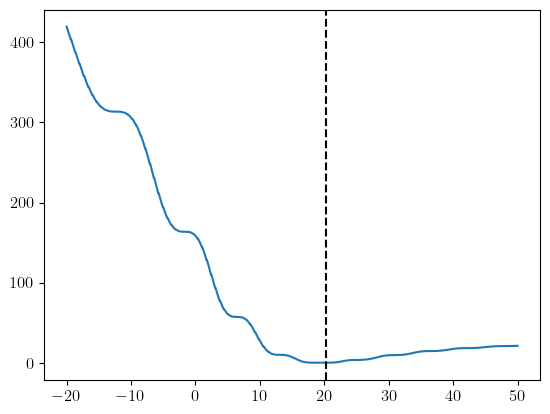

In [32]:
t0_array = np.linspace(-20, 50, 1000)
snr_ratio_target = 5
snr_diff_array = []
for t0 in t0_array:
    snr_diff_array.append(snr_diff(t0, snr_ratio_target))
snr_diff_array = np.array(snr_diff_array)

fig, ax = plt.subplots()
ax.plot(t0_array, snr_diff_array)
ax.axvline(t0_array[np.argmin(snr_diff_array)], color='k', linestyle='--');

In [33]:
t0_array = np.linspace(-10, 50, 1000)
snr_ratio_targets = [1, 5, 10, 15, 20]
t0_targets = []

for snr_ratio_target in snr_ratio_targets:

    snr_diff_array = []
    for t0 in t0_array:
        snr_diff_array.append(snr_diff(t0, snr_ratio_target))
    snr_diff_array = np.array(snr_diff_array)

    t0_targets.append(t0_array[np.argmin(snr_diff_array)])

In [34]:
t0_targets

[np.float64(39.009009009009006),
 np.float64(20.27027027027027),
 np.float64(10.18018018018018),
 np.float64(2.8528528528528536),
 np.float64(-6.216216216216216)]

In [35]:
CCE01_kwargs = dict(
    alpha=1,
    marker='x',
    zorder=2,
    markersize=6,
    )

other_kwargs = dict(
    alpha=0.25,
    marker='o',
    zorder=1,
    markersize=4,
    markeredgewidth=0.
    )

equal_line_kwargs = dict(
    color='#b3b3b3',
    zorder=0.1,
)

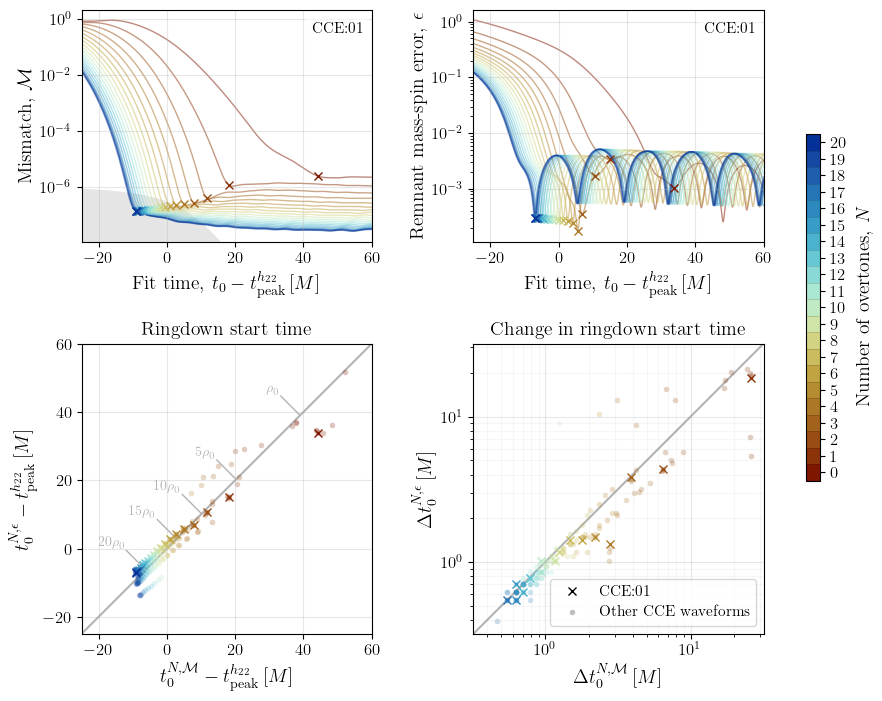

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(11, 9))
fig.subplots_adjust(wspace=0.35, hspace=0.1)

for ax in axs[0,:]:
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

axs[1,0].grid(visible=True, alpha=0.3)

axs[1,1].grid(visible=True, which='major', alpha=0.3)
axs[1,1].grid(visible=True, which='minor', alpha=0.1)

axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

for ax in axs[0,:]:
    ax.set_box_aspect(0.8)

for ax in axs[1,:]:
    ax.set_box_aspect(1)

norm = mpl.colors.Normalize(vmin=N_min-0.5, vmax=N_max+0.5)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs,
    location='right',
    ticks=range(N_min, N_max+1),
    shrink=0.5,
    aspect=25,
)

cbar.set_label(r'Number of overtones, $N$', labelpad=7)

bounds = [n+0.5 for n in range(N_min, N_max)]
for bound in bounds:
    cbar.ax.axhline(bound, color='k', lw=0.5, alpha=0.2)

for ax in axs[0,:]:
    t = ax.text(0.972, 0.9, 'CCE:01', transform=ax.transAxes, ha='right', fontsize=11)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))

for n in N_list:
    
    axs[0,0].plot(
        mm_times,
        sim_info['mm_lists'][n],
        color=cmap(n/N_max),
        zorder=1,
        alpha=0.5,
        lw=1
        )
    
    axs[0,0].plot(
        sim_info['t0_list'][n][0],
        np.exp(sim_info['t0_list'][n][1]),
        color=cmap(n/N_max),
        **CCE01_kwargs
    )
    
    t0E = t0E_data[str(ID)].values[n]

    if n in epsilon_dict:
        epsilon_list = epsilon_dict[n]
    else:
        epsilon_list = epsilon_data[str(n)]

    t0E_epsilon = epsilon_list[np.argmin(np.abs(eps_times - t0E))]
    
    axs[0,1].plot(
        eps_times,
        epsilon_list,
        color=cmap(n/N_max),
        zorder=1,
        alpha=0.5,
        lw=1
        )
    
    axs[0,1].plot(
        t0E,
        t0E_epsilon,
        color=cmap(n/N_max),
        **CCE01_kwargs
    )
    
ylim = axs[0,0].get_ylim()

axs[0,0].fill_between(
        nr_error_times, 
        mm_phase_time, 
        1e-15,
        color='k', 
        alpha=0.1,
        zorder=0,
        linewidth=0
    )
    
axs[0,0].set_xlim(-25, 60)
axs[0,0].set_ylim(ylim)

axs[0,1].set_xlim(-25, 60)

axs[0,0].set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
axs[0,0].set_ylabel(r'Mismatch, $\mathcal{M}$')

axs[0,1].set_xlabel(r'Fit time, $t_0 - t_\mathrm{peak}^{h_{22}}\,[M]$')
axs[0,1].set_ylabel(r'Remnant mass-spin error, $\epsilon$')

# Scatter plot of t0_M vs t0_E
# ----------------------------

for ID_scatter in t0M_data.columns:
    for N in N_list: 

        if ID_scatter == '1':
            kwargs = CCE01_kwargs
        else:
            kwargs = other_kwargs

        axs[1,0].plot(
            t0M_data[ID_scatter].loc[N],
            t0E_data[ID_scatter].loc[N],
            c=cm.roma(N/N_max),
            **kwargs
        )

# Line indicating t0_M = t0_E
# ----------------------------

xlim = axs[1,0].get_xlim()
ylim = axs[1,0].get_ylim()

axs[1,0].plot(
    [-1e3, 1e3],
    [-1e3, 1e3],
    label='$t_0^{N,\mathcal{M}}=t_0^{N,\epsilon}$',
    **equal_line_kwargs
    )

# axs[1,0].set_xlim(xlim)
# axs[1,0].set_ylim(ylim)
axs[1,0].set_xlim([-25, 60])
axs[1,0].set_ylim([-25, 60])

# Scatter plot of Delta_t0_M vs Delta_t0_E
# ----------------------------------------

for ID_scatter in delta_t0_M.columns:
    for N in N_list_Delta_t0: 

        if ID_scatter == '1':
            kwargs = CCE01_kwargs
        else:
            kwargs = other_kwargs

        axs[1,1].plot(
            delta_t0_M[ID_scatter].loc[N],
            delta_t0_E[ID_scatter].loc[N],
            c=cm.roma(N/N_max),
            **kwargs
        )

# Line indicating Delta_t0_M = Delta_t0_E
# ----------------------------------------

xlim = axs[1,1].get_xlim()
ylim = axs[1,1].get_ylim()

axs[1,1].plot(
    [1e-3, 1e3], 
    [1e-3, 1e3], 
    label='$\Delta t_0^{N,\mathcal{M}}=\Delta t_0^{N,\epsilon}$',
    **equal_line_kwargs
    )

axs[1,1].set_xlim(xlim)
axs[1,1].set_ylim(ylim)

# Markers indicating times of equal SNR gain
# ------------------------------------------

length = 8
labels = [r'$\rho_0$', r'$5\rho_0$', r'$10\rho_0$', r'$15\rho_0$', r'$20\rho_0$']
for i, (t0, label) in enumerate(zip(t0_targets, labels)):
    axs[1,0].plot(
        [t0, t0-length*np.cos(np.pi/4)],
        [t0, t0+length*np.sin(np.pi/4)],
        lw=1,
        **equal_line_kwargs,
    )
    if i == -1:
        adjust_x = 2.5
        adjust_y = 0.5
    else:
        adjust_x = -0.5
        adjust_y = 0.5
    axs[1,0].text(
        t0-length*np.cos(np.pi/4)+adjust_x, 
        t0+length*np.sin(np.pi/4)+adjust_y,
        label,
        fontsize=10,
        color=equal_line_kwargs['color'],
        ha='right',
        va='bottom'
    )

# Adjust axis limits
# ------------------

ax0_xlim = axs[1,0].get_xlim()
ax0_ylim = axs[1,0].get_ylim()

ax1_xlim = axs[1,1].get_xlim()
ax1_ylim = axs[1,1].get_ylim()

axs[1,0].set_xlim([min([ax0_xlim[0], ax0_ylim[0]]), max([ax0_xlim[1], ax0_ylim[1]])])
axs[1,0].set_ylim([min([ax0_xlim[0], ax0_ylim[0]]), max([ax0_xlim[1], ax0_ylim[1]])])

axs[1,1].set_xlim([min([ax1_xlim[0], ax1_ylim[0]]), max([ax1_xlim[1], ax1_ylim[1]])])
axs[1,1].set_ylim([min([ax1_xlim[0], ax1_ylim[0]]), max([ax1_xlim[1], ax1_ylim[1]])])

# axs[1,0].set_xticks([-10, 0, 10, 20, 30, 40, 50])

# Legend
# ------

handles = [
    mpl.lines.Line2D([0], [0], color='k', linestyle='None', **CCE01_kwargs),
    mpl.lines.Line2D([0], [0], color='k', linestyle='None', **other_kwargs),
    ]

labels = [
    'CCE:01',
    'Other CCE waveforms',
]

axs[1,1].legend(handles, labels, loc='lower right', fontsize=11)

# ---

axs[1,0].set_title('Ringdown start time')
axs[1,1].set_title('Change in ringdown start time')

axs[1,0].set_xlabel('$t_0^{N,\mathcal{M}} - t_\mathrm{peak}^{h_{22}}\, [M]$')
axs[1,0].set_ylabel('$t_0^{N,\epsilon} - t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[1,1].set_xlabel('$\Delta t_0^{N,\mathcal{M}}\, [M]$')
axs[1,1].set_ylabel('$ \Delta t_0^{N,\epsilon}\, [M]$')

fig.savefig('figures/ringdown_start_time.pdf', bbox_inches='tight')